# PHAS0030 Assignment Week 7

In this notebook, we will be performing a molecular dynamics simulation of the Lennard-Jones model of Ne. The equation for the Lennard-Jones potential is given by: 

$$ V(r) = 4 \: \epsilon \: [ (\frac{\sigma}{r})^{12} - (\frac{\sigma}{r})^6 ] $$

where $r$ is radius, and $\sigma$ and $\epsilon$ are constants.
This equation describes the potential of a charged particle as it approaches another charged particle.  

In [15]:
# Appropriate imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
rng = np.random.default_rng()

### 1. Setting up the force function

Implement the equation: 

$$ V(r) = 4 \: \epsilon \: [ (\frac{\sigma}{r})^{12} - (\frac{\sigma}{r})^6 ] $$

In [10]:
# Equation from Session 7 in-class notebook, Section 5, Question 1 
def find_forces_LJ(pos,Npart,sigma,epsilon,boxlen):
    """Evaluate the force due to Lennard-Jones potential
    
    Inputs:
    pos             Positions (Npart x 3 array)
    Npart           Number of particles
    sigma, epsilon  LJ parameters
    boxlen          Length of simulation cell
    
    Output:
    energy          LJ energy
    force           Forces on particles (Npart x 3 array)
    """
    force = np.zeros((Npart,3)) #storage array
    energy = 0.0
    sigma6 = sigma**6           #first fraction
    sigma12 = sigma6*sigma6     #second fraction
    for i in range(Npart-1):
        for j in range(i+1,Npart):
            dr = pos[j]-pos[i]
            # Ensure that we interact with the closest particle through periodic boundaries
            # For larger arrays, using np.mod(dr,boxlen) is likely to be more efficient
            dr -= boxlen*np.rint(dr/boxlen)
            dr2 = np.sum(dr*dr)  # dot product
            dr2i = 1.0/dr2
            dr6i = dr2i*dr2i*dr2i   # magnitude
            fij= 24.0*epsilon*dr*dr2i*dr6i*(sigma6 - 2.0*sigma12*dr6i)
            force[i] += fij
            force[j] -= fij
            energy += 4.0*epsilon*dr6i*(sigma12*dr6i - sigma6)
    return energy, force

### 2. Set up the lattice and the simulation parameters



In [11]:
# Initialisation
Nsteps = 10000
kB = 1.38e-23 
sigma = 0.275e-9
epsilon = 36*kB  
mass = 20.2*1.673e-27
Ncells = 4 
boxlen = 1.1 * 2 **1/6 * sigma
Npart = Ncells ** 3                     # 64 particles
rbox3 = np.zeros([Nsteps,Npart,3])
vbox3 = np.zeros([Nsteps,Npart,3])
count = 0
for i in range(Ncells):
    for j in range(Ncells):
        for k in range(Ncells):
            rbox3[0,count] = (1.0/Ncells)*boxlen*np.array([i,j,k])
            count += 1

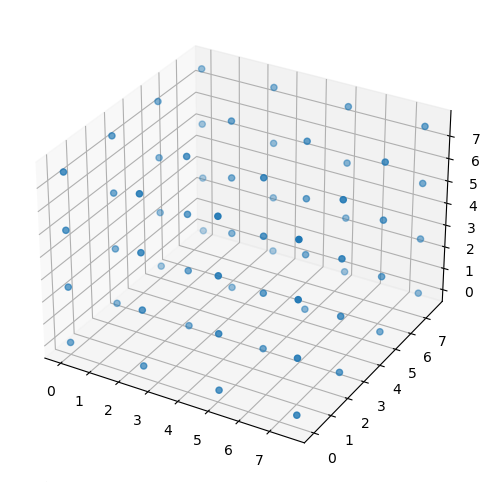

In [12]:
# plot lattice
fig_3d5 = plt.figure(figsize=(10,6))
ax3d5 = fig_3d5.add_subplot(111,projection='3d')
ax3d5.scatter(rbox3[0,:,0],rbox3[0,:,1],rbox3[0,:,2])
plt.title('Lattice');

### 3. Initialise velocities

In [111]:
# Initialise velocities
initT  = 50          # K
# The initial distribution can have an arbitrary scaling
vbox3[0] = rng.standard_normal(size=(Npart,3))
# These line rescales the velocities
v_scale = np.sqrt(3*Npart*kB*initT/(mass*np.sum(vbox3[0]*vbox3[0])))
vbox3[0] *= v_scale

energy = np.zeros(Nsteps)
temp = np.zeros(Nsteps)
e, f = find_forces_LJ(rbox3[0],Npart,sigma,epsilon,boxlen)
energy[0] = e
temp[0] = mass*np.sum(vbox3[0]*vbox3[0])/(3*Npart*kB)
acc = f/mass
dt = 1e-15 # s 
MSD = np.zeros(Nsteps)

### 4. Run simulation


In [112]:
# Equation from Session 7 in-class notebook, Section 5, Question 3
def pbc(r,boxlen):
    """Implements periodic boundary conditions for a particle"""
    r_new = np.mod(r,boxlen)
    return r_new

In [113]:
for step in range(1, Nsteps):
    rbox3[step] = rbox3[step-1] + dt*vbox3[step-1] + 0.5*dt*dt*acc # acc at step-1
    # Periodic boundaries
    rbox3[step] = pbc(rbox3[step],boxlen)
    energy[step], f = find_forces_LJ(rbox3[step],Npart,sigma,epsilon,boxlen)
    acc_next = f/mass
    vbox3[step] =  vbox3[step-1] + 0.5*dt*(acc_next + acc)
    temp[step] = mass*np.sum(vbox3[step]*vbox3[step])/(3*Npart*kB)
    acc = acc_next
    # Calculate mean-squared displacement
    MSD[step-1] = np.sum(np.linalg.norm(rbox3[step] - rbox3[0],axis=1) ** 2 ) # find difference in magnitude, square, then sum 
MSD /= Npart # 1/N coefficient

Text(0, 0.5, 'Mean squared displacement (m)')

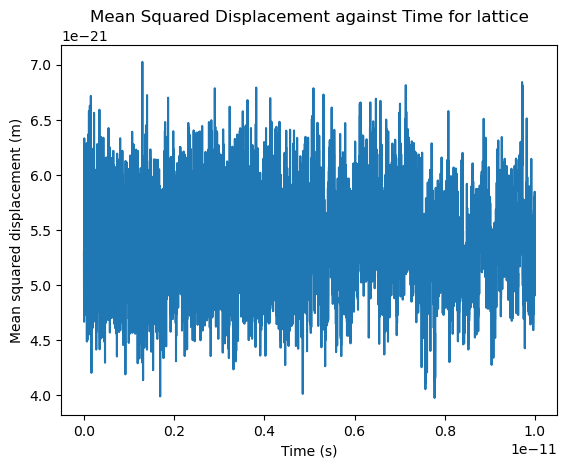

In [121]:
time = dt*np.arange(1,Nsteps-1)
plt.plot(time,MSD[1:-1])
plt.title("Mean Squared Displacement against Time for lattice")
plt.xlabel("Time (s)")
plt.ylabel("Mean squared displacement (m)")

Text(0, 0.5, 'Mean squared displacement / (6t) ')

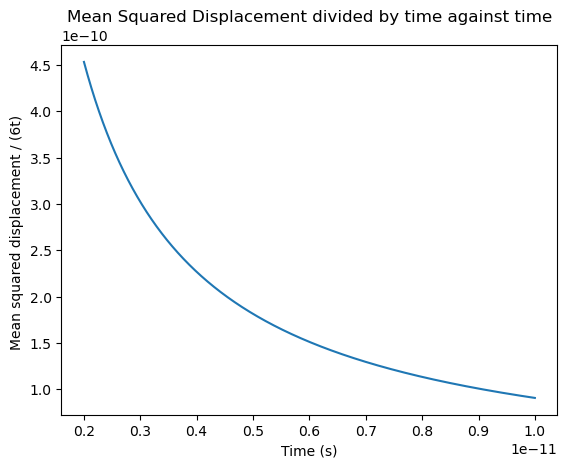

In [124]:
plt.plot(time[2000:], MSD[2000] / (6 *time[2000:]));
plt.title("Mean Squared Displacement divided by time against time")
plt.xlabel("Time (s)")
plt.ylabel("Mean squared displacement / (6t) ")

As seen from the graph, the mean squared displacement is about to converge to a single value. Should our simulation be longer, it eventually will.  

### 5. Calculate the integral

In [125]:
Int = np.zeros(Nsteps) # array for values
another_sum = np.zeros(Nsteps-1)
for step in range(1,Nsteps):
    summation = 0  
    for val in range(Npart):
        summation += np.dot(vbox3[step, val], vbox3[0, val]) # dot product of each velocity value and sum over
    Int[step] = Int[step-1] + summation * dt # rectangle method
Int /= 3*Npart

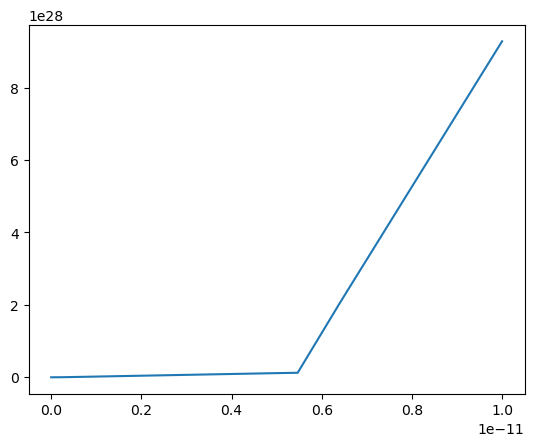

In [128]:
time = dt*np.arange(Nsteps)
plt.plot(time,Int);

## Conclusion

From the graph above, it looks like my calculations and code were incorrect as the integral does not converge to a single value. I tried to look for any errors within my code or calculations but wasn't able to find any. 
Should the integral have converged, it's clear that the integral method is much more efficient than using the mean standard displacement equation, as the latter would take several minutes to compute while computing the integral was almost instant. 